# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# !cp ../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv ./data/
# !cp ../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv ./data/
# !cp ../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv ./data/
# !cp ../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv ./data/

## Load Data

In [3]:
# load in the data
azdias_orig = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';')

In [2]:
# load in the data
customers_orig = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Demographics data for the general population of Germany

In [4]:
# print the shape of the population dataframe, and print the first few rows
print(azdias_orig.shape)
azdias_orig.head()

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
azdias_orig.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
LNR                            int64
AGER_TYP                       int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015                object
CAMEO_INTL_2015                object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float6

In [6]:
azdias_orig.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [7]:
azdias_orig.loc[:, azdias_orig.dtypes=='object'].describe(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,792242,792242,792242,634108,798073,798073
unique,45,19,43,35,5162,2
top,6B,8,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,56672,78023,77576,195338,383738,629528


In [8]:
# remove EINGEFUEGT_AM column
azdias_orig_EINGEFUEGT_AM = azdias_orig[['EINGEFUEGT_AM']].copy()
azdias_orig.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

In [9]:
azdias_orig.loc[:, azdias_orig.dtypes=='object'].describe(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
count,792242,792242,792242,634108,798073
unique,45,19,43,35,2
top,6B,8,51,D19_UNBEKANNT,W
freq,56672,78023,77576,195338,629528


## load azdias_attribute_info (include missing values info for each column)

In [10]:
azdias_attribute_info = pd.read_csv('./data/AZDIAS_Attributes_Info.csv', sep=';')

In [11]:
print (azdias_attribute_info.shape)
azdias_attribute_info.head(20)

(363, 4)


,attribute,type,missing_or_unknown,information_level
0,AGER_TYP,categorical,"[-1,0]",person
1,ALTERSKATEGORIE_GROB,ordinal,"[-1,0,9]",person
2,ALTER_HH,interval,[0],household
3,ANREDE_KZ,categorical,"[-1,0]",person
4,ANZ_HAUSHALTE_AKTIV,numeric,[],building
5,ANZ_HH_TITEL,numeric,[],building
6,ANZ_PERSONEN,numeric,[],household
7,ANZ_TITEL,numeric,[],household
8,BALLRAUM,ordinal,[-1],postcode
9,CAMEO_DEUG_2015,categorical,"[-1,X]",microcell_rr4


## process missing data

In [12]:
class ProcessMissingValues(BaseEstimator, TransformerMixin):
    def __init__(self, attr_info):
        self.map = {}
        for i in range(len(attr_info)):
            missing_str = attr_info.missing_or_unknown[i]
            missing_list = missing_str.strip('[]').split(',')
            missing_list = [item for item in missing_list if item]
            for j in range(len(missing_list)):
                try:
                    num = int(missing_list[j])
                    missing_list.append(num)
                except:
                    continue
            self.map[attr_info.attribute[i]] = missing_list

    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for col_name in self.map:
            print (f'replacing {col_name} missing values ... ')
            for item in self.map[col_name]:
                X.loc[X[col_name]==item, col_name]=np.nan
        return X
    

In [85]:
# this step takes long to finish, the process results will be saved to a csv file 
process_missing_value = ProcessMissingValues(attr_info=azdias_attribute_info)
azdias_nan = process_missing_value.fit_transform(azdias_orig)

replacing AGER_TYP missing values ... 
replacing ALTERSKATEGORIE_GROB missing values ... 
replacing ALTER_HH missing values ... 
replacing ANREDE_KZ missing values ... 
replacing ANZ_HAUSHALTE_AKTIV missing values ... 
replacing ANZ_HH_TITEL missing values ... 
replacing ANZ_PERSONEN missing values ... 
replacing ANZ_TITEL missing values ... 
replacing BALLRAUM missing values ... 
replacing CAMEO_DEUG_2015 missing values ... 
replacing CAMEO_DEU_2015 missing values ... 
replacing CAMEO_INTL_2015 missing values ... 
replacing CJT_GESAMTTYP missing values ... 
replacing D19_BANKEN_ANZ_12 missing values ... 
replacing D19_BANKEN_ANZ_24 missing values ... 
replacing D19_BANKEN_DATUM missing values ... 
replacing D19_BANKEN_DIREKT missing values ... 
replacing D19_BANKEN_GROSS missing values ... 
replacing D19_BANKEN_LOKAL missing values ... 
replacing D19_BANKEN_OFFLINE_DATUM missing values ... 
replacing D19_BANKEN_ONLINE_DATUM missing values ... 
replacing D19_BANKEN_ONLINE_QUOTE_12 miss

replacing KBA13_FIAT missing values ... 
replacing KBA13_FORD missing values ... 
replacing KBA13_HALTER_20 missing values ... 
replacing KBA13_HALTER_25 missing values ... 
replacing KBA13_HALTER_30 missing values ... 
replacing KBA13_HALTER_35 missing values ... 
replacing KBA13_HALTER_40 missing values ... 
replacing KBA13_HALTER_45 missing values ... 
replacing KBA13_HALTER_50 missing values ... 
replacing KBA13_HALTER_55 missing values ... 
replacing KBA13_HALTER_60 missing values ... 
replacing KBA13_HALTER_65 missing values ... 
replacing KBA13_HALTER_66 missing values ... 
replacing KBA13_HERST_ASIEN missing values ... 
replacing KBA13_HERST_AUDI_VW missing values ... 
replacing KBA13_HERST_BMW_BENZ missing values ... 
replacing KBA13_HERST_EUROPA missing values ... 
replacing KBA13_HERST_FORD_OPEL missing values ... 
replacing KBA13_HERST_SONST missing values ... 
replacing KBA13_KMH_110 missing values ... 
replacing KBA13_KMH_140 missing values ... 
replacing KBA13_KMH_180 mi

In [86]:
azdias_nan.to_csv('./data/Udacity_AZDIAS_052018_nan.csv', sep=';')

In [13]:
# reload processed data
azdias_nan = pd.read_csv('./data/Udacity_AZDIAS_052018_nan.csv', sep=';')

In [14]:
azdias_nan.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [15]:
nan_num = azdias_nan.isnull().sum(axis=0)
nan_num_frac = nan_num / len(azdias_nan)
nan_num_frac

Unnamed: 0              0.000000
LNR                     0.000000
AGER_TYP                0.769554
AKT_DAT_KL              0.082470
ALTER_HH                0.348137
                          ...   
WOHNDAUER_2008          0.082470
WOHNLAGE                0.104517
ZABEOTYP                0.000000
ANREDE_KZ               0.000000
ALTERSKATEGORIE_GROB    0.003233
Length: 366, dtype: float64

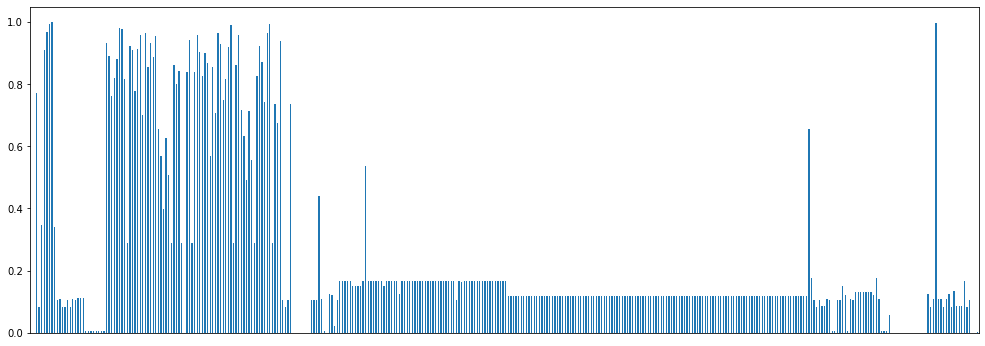

In [16]:
nan_num_frac.plot(kind='bar', figsize=(17, 6))
plt.xticks([])
plt.show()

base on this plot, lots of attributes have too many NaN values and that's not ideal for data modeling. The attributes with more than 60% NaN values will be dropped for the following analysis

In [17]:
nan_num_sorted = azdias_nan.isnull().sum(axis=0).sort_values(ascending=False)
nan_num_sorted_frac = nan_num_sorted / len(azdias_nan)
nan_num_sorted_frac

ALTER_KIND4               0.998648
TITEL_KZ                  0.997576
ALTER_KIND3               0.993077
D19_VERSI_ONLINE_DATUM    0.991702
D19_TELKO_ONLINE_DATUM    0.990796
                            ...   
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_SPARER             0.000000
FINANZ_MINIMALIST         0.000000
FINANZ_HAUSBAUER          0.000000
Unnamed: 0                0.000000
Length: 366, dtype: float64

In [ ]:
# 

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')